In [1]:
import numpy as np
import itertools
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

import re

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import pandas as pd

import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

np.random.seed(1234)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#Task 1: Acquire, preprocess, and analyze the data

Dataset 1: 20 news group

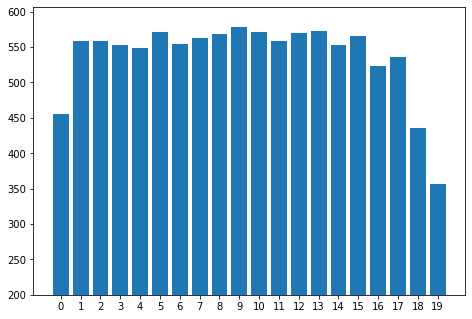

In [10]:
# the type of twenty_train is a scikit-learn "Bunch"
twenty_news = fetch_20newsgroups(subset = 'train' , remove = (["headers", "footers", "quotes"]))  # twenty_news.data is of type list, twenty_news.data[i] is of type string
known_labels = twenty_news.target  # type: np.ndarray | shape: (11314,)


# convert all uppercase letters to lowercase
lower_news_data = [x.lower() for x in twenty_news.data]  # type of data: list

# helper function that preprocess news data by removing all punctuations
def rm_punc(sen_list):
  return [re.sub(r'[^\w\s]', '', sentence) for sentence in sen_list]
########## remove all punctuations in text
no_punc_news_data = rm_punc(lower_news_data)


######################### lemmatize words and remove stopwords
lemmatizer = WordNetLemmatizer()

# helper function that assign tag to a word
def pos_tagger(nltk_tag):
  if nltk_tag.startswith('J'):
    return wordnet.ADJ
  elif nltk_tag.startswith('V'):
    return wordnet.VERB
  elif nltk_tag.startswith('N'):
    return wordnet.NOUN
  elif nltk_tag.startswith('R'):
    return wordnet.ADV
  else:         
    return None

# a helper function that tokenize sentence and lemmalize all words in that sentence
def lem_stp_sentence(sentence):
  stpwords = stopwords.words('english')
  lem_list = []
  pos_tagged_words = nltk.pos_tag(nltk.word_tokenize(sentence))
  wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged_words))
  for word, tag in wordnet_tagged:
    if word not in stpwords:
      if tag is None:
        lem_list.append(word)
      else:
        lem_list.append(lemmatizer.lemmatize(word, tag))
  return ' '.join(lem_list)

final_news_data = [lem_stp_sentence(s) for s in no_punc_news_data]


######################### create count vectorizer
cv = CountVectorizer()
X_news_counts = cv.fit_transform(final_news_data)  # X_news_counts is of type array

X_train_counts = X_news_counts[:10748]
X_test_counts = X_news_counts[10748:]
news_train_labels = known_labels[:10748].tolist()
news_test_labels = known_labels[10748:].tolist()


######################### raw data
news_features = cv.get_feature_names_out()
cv_train_raw1 = CountVectorizer(vocabulary = news_features)
raw_train_counts1 = cv_train_raw1.fit_transform(no_punc_news_data)[:10748]

cv_test_raw1 = CountVectorizer(vocabulary = news_features)
raw_test_counts1 = cv_test_raw1.fit_transform(no_punc_news_data)[10748:]


######################### Analyze data in the training set
# get all possible labels
unique_labels = list(set(news_train_labels))
#print(unique_labels)
cat_counter = dict.fromkeys(unique_labels, 0)
#print(cat_counter)
rows, columns = X_train_counts.shape
for i in range(rows):
  label = news_train_labels[i]
  cat_counter[label] += 1

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
news_train_x = list(map(str, range(0, 20)))
news_train_y = list(cat_counter.values())

ax.bar(news_train_x, news_train_y)
ax.set_ylim(bottom=200)
plt.show()

# transfer from occurences to frequencies
tf_train_trans = TfidfTransformer(use_idf=False).fit(X_train_counts)
tf_test_trans = TfidfTransformer(use_idf=False).fit(X_test_counts)

X_train_freq = tf_train_trans.transform(X_train_counts)
X_test_freq = tf_test_trans.transform(X_test_counts)

news_train_labels = known_labels[:10748]
news_test_labels = known_labels[10748:]


Dataset 2: Sentiment 140

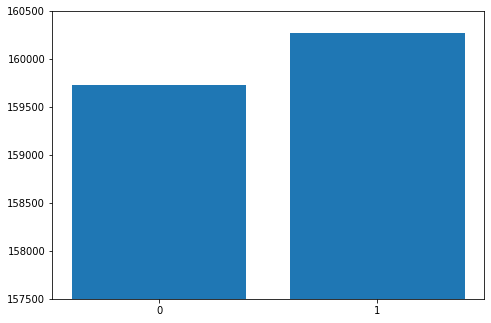

In [11]:
load_sent140_train_df = pd.read_csv("../training.1600000.processed.noemoticon.csv", encoding = 'latin-1')  # the return type of load_sent140_train is DataFrame
load_sent140_test_df = pd.read_csv("../new_testdata.manual.2009.06.14.csv", encoding = 'latin-1')

# get the np representation of loaded sentiment140 data
sent140_train_np = load_sent140_train_df.values  # type: np.ndarray | shape of this np is: (1599999, 6)
sent140_test_np = load_sent140_test_df.values
# shuffle the original data
np.random.shuffle(sent140_train_np)
np.random.shuffle(sent140_test_np)
# extract only the label and the message columns in data
sent140_train_needed = sent140_train_np.compress([True, False, False, False, False, True], axis = 1)  # type: np.ndarray | shape: (1599999, 2)
sent140_test_needed = sent140_test_np.compress([True, False, False, False, False, True], axis = 1)
# get only 20% of the original data (which are 320000 lines)
sent140_train_extract = sent140_train_np.compress([True, False, False, False, False, True], axis = 1)[:320000]  # type: np.ndarray | shape: (320000, 2)
sent140_train_msg = sent140_train_extract.compress([False, True], axis = 1).flatten()
sent140_train_labels = sent140_train_extract.compress([True, False], axis = 1).flatten()[:320000].astype(int)  # type: np.ndarray | shape: (320000,)
sent140_train_labels[sent140_train_labels > 0] = 1

sent140_test_msg = sent140_test_needed.compress([False, True], axis = 1).flatten()
sent140_test_labels = sent140_test_needed.compress([True, False], axis = 1).flatten().astype(int)
sent140_test_labels[sent140_test_labels > 0] = 1

msg_train_list = sent140_train_msg.tolist()  # convert ndarray of messages to a LIST of STRINGS | shape of msg_list: 1599999
msg_test_list = sent140_test_msg.tolist()

# convert all uppercase letters to lowercase
lower_msg_train_data = [x.lower() for x in msg_train_list]  # type of data: list
lower_msg_test_data = [x.lower() for x in msg_test_list]
# remove all punctuations
no_punc_msg_train_data = rm_punc(lower_msg_train_data)
no_punc_msg_test_data = rm_punc(lower_msg_test_data)


########## lemmatize words and remove stopwords
# generate a new lemmatizer
lemmatizer2 = WordNetLemmatizer()

final_msg_train = [lem_stp_sentence(s) for s in no_punc_msg_train_data]
final_msg_test = [lem_stp_sentence(s) for s in no_punc_msg_test_data]


# feature selection and vectorizer initialization
cv2 = CountVectorizer(min_df = 5)  # ignore words that appear in less than 5 instances
X_sent140_train_counts = cv2.fit_transform(final_msg_train)  # shape: (320000, 20999)


######################### Analyze data in the training set
# get all possible labels
unique_labels = [0, 1]
#print(unique_labels)
cat_counter = dict.fromkeys(unique_labels, 0)
#print(cat_counter)
rows, columns = X_sent140_train_counts.shape
for i in range(rows):
  label = sent140_train_labels[i]
  cat_counter[label] += 1

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
news_train_x = list(map(str, range(0, 2)))
news_train_y = list(cat_counter.values())

ax.bar(news_train_x, news_train_y)
ax.set_ylim(top = 160500, bottom = 157500)
plt.show()



# get all feature names in X_sent140_train_counts
sent140_features = cv2.get_feature_names_out()  # type: ndarray | shape: (21055,)
# build the testing vectorizer with features from training set
cv3 = CountVectorizer(min_df = 5, vocabulary = sent140_features)
X_sent140_test_counts = cv3.fit_transform(final_msg_test)  # shape: (358, 123)


######################### raw data
cv_train_raw2 = CountVectorizer(vocabulary = sent140_features)
raw_train_counts2 = cv_train_raw2.fit_transform(no_punc_msg_train_data)

cv_test_raw2 = CountVectorizer(vocabulary = sent140_features)
raw_test_counts2 = cv_test_raw2.fit_transform(no_punc_msg_test_data)


# if not set max_df and min_df, the shape of X_sent140_train_counts is: (320000, 218590)
# if min_df = 5, the shape of X_sent140_train_counts is: (320000, 19772)
# if set to max_df = 0.8, min_df = 5000, the shape of X_sent140_train_counts is: (320000, 69)
# if set to max_df = 0.9, min_df = 1000, the shape of X_sent140_train_counts is: (320000, 376)

tf_trans2 = TfidfTransformer(use_idf=False).fit(X_sent140_train_counts)
tf_trans3 = TfidfTransformer(use_idf=False).fit(X_sent140_test_counts)
X_sent140_train_freq = tf_trans2.transform(X_sent140_train_counts)
X_sent140_test_freq = tf_trans3.transform(X_sent140_test_counts)






#Task 2: Implement Naive Bayes and k-fold cross validation

##Multinomial Naive Bayes:

### Fit the Data:

In [12]:
class MultinomialNaiveBayes:
    
    def __init__(self, alpha=1):
        self.alpha = alpha
        return
    
    def fit(self, x, y):
        N, D = x.shape
        C = np.unique(y).shape[0]
        # one parameter for each feature conditioned on each class
        Nyi = np.zeros((C,D))
        Nc = np.zeros(C) # number of instances in class c
        Ny = np.zeros(C)
        for c in range(C):
            x_c = x[y == c]        #slice all the elements from class c
            Nc[c] = x_c.shape[0]       #get number of elements of class c
            Nyi[c,:] = np.sum(x_c,0)     #counts of word d in all documents labelled c
            Ny[c] = np.sum(x_c)   #total word count in all documents labelled c
        self.Nc = Nc
        self.N_yi = Nyi   # C x D 
        self.N_y = Ny
        self.D = D
        self.pi = (Nc)/(N)  #Laplace smoothing (using alpha_c=1 for all c)
        self.C = C
        numerator = self.N_yi + self.alpha
        denominator = self.N_y + (self.alpha * self.D)
        denominator = denominator[:,None]
        self.thetak = numerator/denominator 
        return self

    def __eq__(self, other):
        return self.alpha == other.alpha

###Prediction for new data


In [13]:
def logsumexp(Z):      # dimension N x C
    Zmax = np.max(Z,axis=1)[:,None]     # max over C
    log_sum_exp = np.log(np.sum(np.exp(Z - Zmax), axis=1))
    Zmax = Zmax[:,0]
    log_sum_exp = Zmax + log_sum_exp
    log_sum_exp = log_sum_exp[:,None]
    return log_sum_exp

def _logtheta(self, x_i, i, l):
    Nyi = self.N_yi[l,i]
    Ny  = self.N_y[l]
    numerator = Nyi + self.alpha
    denominator = Ny + (self.alpha * self.D)
    return  x_i*np.log((numerator / denominator))
MultinomialNaiveBayes._logtheta = _logtheta

def _loglikelihood(self, X, nt, l):
    tmp = []
    for h in X[nt].nonzero()[1]:   
      tmp.append(self._logtheta(X[nt,h], h, l))
    return np.sum(tmp)
MultinomialNaiveBayes._loglikelihood = _loglikelihood

def predict(self, X):
    Nt, D = X.shape
    log_prior = np.log(self.pi)[None,:]    #turn log_pi to N * C
    log_likelihood = np.zeros((Nt, self.C))
    for i in range(Nt):
      for l in range(self.C):
        log_likelihood[i][l] = self._loglikelihood(X,i,l)        
    log_posterior = log_prior + log_likelihood
    self.posterior = np.exp(log_posterior - logsumexp(log_posterior))     
    y_pred = np.argmax(self.posterior, axis=1) 
    return y_pred   # dimension N x C
MultinomialNaiveBayes.predict = predict

## Gaussian Naive Bayes

### Fit the data

In [ ]:
class GaussianNaiveBayes:
    
    def __init__(self):
        return
    
    def fit(self, x, y):
        N, D = x.shape
        C = np.max(y) + 1
        # one parameter for each feature conditioned on each class
        mu, sigma = np.zeros((C,D)), np.zeros((C,D))
        Nc = np.zeros(C) # number of instances in class c
        # for each class get the MLE for the mean and std
        for c in range(C):
            x_c = x[y == c]                         #slice all the elements from class c
            Nc[c] = x_c.shape[0]                      #get number of elements of class c
            mu[c,:] = np.mean(x_c,0)                  #mean of features of class c
            for i in ramge(D):
              col = x_c.getcol(i)
              Nt = col.shape[0]
              sqr = col.copy() # take a copy of the col
              sqr.data **= 2 # square the data, i.e. just the non-zero data
              variance = sqr.sum()/N - col.mean()**2
            sigma[c,:] = np.std(x_c,0)               #std of features of class c
        self.mu = mu                                  # C x D
        self.sigma = sigma                            # C x D
        self.pi = (Nc+1)/(N+C)                        #Laplace smoothing (using alpha_c=1 for all c) you can derive using Dirichlet's distribution
        return self

### Prediction for new data

In [ ]:
def logsumexp(Z):                                                # dimension C x N
    Zmax = np.max(Z,axis=0)[None,:]                              # max over C
    log_sum_exp = Zmax + np.log(np.sum(np.exp(Z - Zmax), axis=0))
    return log_sum_exp

def predict(self, xt):
    Nt, D = xt.shape
    # for numerical stability we work in the log domain
    # we add a dimension because this is added to the log-likelihood matrix 
    # that assigns a likelihood for each class (C) to each test point, and so it is C x N
    log_prior = np.log(self.pi)[:, None]
    # logarithm of the likelihood term for Gaussian 
    # the first two terms are the logarithm of the normalization term in the Gaussian and the final term is the exponent in the Gaussian. 
    # Notice that we are adding dimensions (using None) to model parameters and data to make this evaluation. 
    # The reason is that sigma and mu are C x D, while the data x is N x D. We operate on a C x N x D shape by increasing the number of dimensions when needed
    log_likelihood = -.5 * np.log(2*np.pi) - np.log(self.sigma[:,None,:]) -.5 * (((xt[None,:,:] - self.mu[:,None,:])/self.sigma[:,None,:])**2)
    # now we sum over the feature dimension to get a C x N matrix (this has the log-likelihood for each class-test point combination)
    log_likelihood = np.sum(log_likelihood, axis=2)
    # posterior calculation
    log_posterior = log_prior + log_likelihood
    posterior = np.exp(log_posterior - logsumexp(log_posterior))
    return posterior.T                                                  # dimension N x C

GaussianNaiveBayes.predict = predict

## Evaluation of accuracy

In [14]:
def evaluate_acc(y_test, y_pred):
  accuracy = np.sum(y_pred == y_test)/y_pred.shape[0]
  return accuracy

## Cross-Validation

### cross_validation_split

In [15]:
def cross_validate_split(n, n_folds=5):
    #get the number of data samples in each split
    n_val = n // n_folds
    inds = np.random.permutation(n)
    inds = []
    for f in range(n_folds):
        tr_inds = []
        #get the validation indexes
        val_inds = list(range(f * n_val, (f+1)*n_val))
        #get the train indexes
        if f > 0:
            tr_inds = list(range(f*n_val))
        if f < n_folds - 1:
            tr_inds = tr_inds + list(range((f+1)*n_val, n))
        #The yield statement suspends function’s execution and sends a value back to the caller
        #but retains enough state information to enable function to resume where it is left off
        yield tr_inds, val_inds


# helper function that outputs a list of accuracy
def getAccList(model, X, Y, num_folds):
    num_instances, num_features = X.shape
    valid_predicts = []
    for f, (tr, val) in enumerate(cross_validate_split(num_instances, num_folds)):
      #print(f)
      #print(cross_validate_split(num_instances, num_folds))
      model = model.fit(X[tr], Y[tr])
      y_pred = model.predict(X[val])
      accuracy = evaluate_acc(Y[val], y_pred)
      valid_predicts.append(accuracy)
    return valid_predicts



# return a mean value, not a list
def kfoldCV(acc_list):
    result = np.mean(acc_list)
    return result



# function that takes the given model and compute kfold average on each input hpara
# model is of type object, hpara is of type dictionary (key: name of parameter, value: a list of hyperparameter values)
# example: findBestHP(DecisionTree(), {"max_depth": [2, 3, 4, 5, 6]}) | dict(max_depth = [2, 3, 4, 5, 6])
# example: findBestHP(LogisticRegression(), {"solver": [‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’],
#                                            "penalty": [‘none’, ‘l1’, ‘l2’, ‘elasticnet’], 
#                                            "C": [100, 10, 1.0, 0.1, 0.01]})
def findBestHP(model, X, Y, hpara):
    corres_results = dict()  # the key of this dict should be a list of hyperparameter values, and the value of keys should be mean result
    hp_num = len(hpara)

    if (type(model) == type(KNeighborsClassifier())):
      options = hpara.get(list(hpara.keys())[0])
      for value in options:
        new_obj = KNeighborsClassifier(n_neighbors = value)
        corres_results[value] = kfoldCV(getAccList(new_obj, X, Y, 5))
      return max(corres_results, key = corres_results.get)

    elif (type(model) == type(DecisionTreeClassifier())):
      options = hpara.get(list(hpara.keys())[0])
      for value in options:
        new_obj = DecisionTreeClassifier(max_depth = value)
        corres_results[value] = kfoldCV(getAccList(new_obj, X, Y, 5))
      return max(corres_results, key = corres_results.get)

    elif (type(model) == type(MultinomialNaiveBayes())):
      options = hpara.get(list(hpara.keys())[0])
      for value in options:
        new_obj = MultinomialNaiveBayes(alpha = value)
        corres_results[value] = kfoldCV(getAccList(new_obj, X, Y, 5))
      return max(corres_results, key = corres_results.get)

    elif (type(model) == type(LogisticRegression())):
      combined = [(slr, c) for slr in hpara.get("solver") for c in hpara.get("C")]
      for tp in combined:
        new_obj = LogisticRegression(solver = tp[0], penalty = 'l2', C = tp[2], max_iter = 1000)
        corres_results[tp] = kfoldCV(getAccList(new_obj, X, Y, 5))
      return max(corres_results, key = corres_results.get)

    return None



######################## find the best hyperparameter of each model under different datasets
# dictionary of hyperparameters
knn_dict = {"K": [3, 4, 5, 6, 7]}
mn_dict = {"alpha": [1, 2, 3, 4, 5]}
lr_dict = {"solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], "C": [100, 10, 1.0, 0.1, 0.01]}

knn_model = KNeighborsClassifier()
mn_model = MultinomialNaiveBayes()
lr_model = LogisticRegression()


############################### find the best value for hyperparameter


# KNN best hyperparameter in dataset 1 | best K value: 4
knn1 = findBestHP(knn_model, X_train_counts, news_train_labels, knn_dict)
print("The best hyperparameter value 'K' of model KNN on 20 news group dataset is: ", knn1)
# KNN best hyperparameter in dataset 2
knn2 = findBestHP(knn_model, X_sent140_train_counts, sent140_train_labels, knn_dict)
print("The best hyperparameter value 'K' of model KNN on sentiment140 dataset is: ", knn2)


# Multinomial best hyperparameter in dataset 1
mn1 = findBestHP(mn_model, X_train_counts, news_train_labels, mn_dict)
print("The best hyperparameter value 'K' of model KNN on 20 news group dataset is: ", mn1)
# Multinomial best hyperparameter in dataset 2
mn2 = findBestHP(mn_model, X_sent140_train_counts, sent140_train_labels, mn_dict)
print("The best hyperparameter value 'K' of model KNN on sentiment140 dataset is: ", mn2)


# Logistic Regression best hyperparameter in dataset 1
lr1 = findBestHP(lr_model, X_train_counts, news_train_labels, lr_dict)
print("The best hyperparameter value 'K' of model KNN on 20 news group dataset is: ", lr1)
# Logistic Regression best hyperparameter in dataset 2
lr2 = findBestHP(lr_model, X_sent140_train_counts, sent140_train_labels, lr_dict)
print("The best hyperparameter value 'K' of model KNN on sentiment140 dataset is: ", lr2)



'\n# KNN best hyperparameter in dataset 1 | best K value: 4\nknn1 = findBestHP(knn_model, X_train_counts, news_train_labels, knn_dict)\nprint("The best hyperparameter value \'K\' of model KNN on 20 news group dataset is: ", knn1)\n# KNN best hyperparameter in dataset 2\nknn2 = findBestHP(knn_model, X_sent140_train_counts, sent140_train_labels, knn_dict)\nprint("The best hyperparameter value \'K\' of model KNN on sentiment140 dataset is: ", knn2)\n\n\n# Multinomial best hyperparameter in dataset 1\nmn1 = findBestHP(mn_model, X_train_counts, news_train_labels, mn_dict)\nprint("The best hyperparameter value \'K\' of model KNN on 20 news group dataset is: ", mn1)\n# Multinomial best hyperparameter in dataset 2\nmn2 = findBestHP(mn_model, X_sent140_train_counts, sent140_train_labels, mn_dict)\nprint("The best hyperparameter value \'K\' of model KNN on sentiment140 dataset is: ", mn2)\n\n# Logistic Regression best hyperparameter in dataset 1\nlr1 = findBestHP(lr_model, X_train_counts, news_t

In [ ]:
# MultinomialNB
obj = MultinomialNaiveBayes()
para = {"alpha": [1, 2, 3]}
print(findBestHP(obj, X_train_counts, news_train_labels, para))

#Task 3: Run experiments

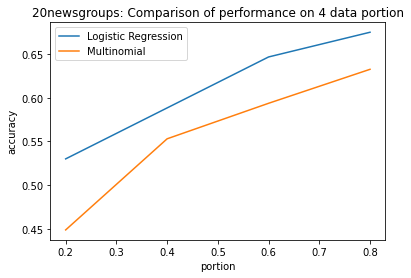

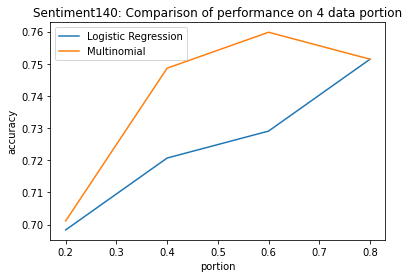

The accuracy of KNN on raw data 1 is:  0.21908127208480566
The accuracy of KNN on raw data 2 is:  0.6703910614525139
The accuracy of Logistic Regression on raw data 1 is:  0.6431095406360424
The accuracy of Logistic Regression on raw data 2 is:  0.8044692737430168
The accuracy of Multinomial Naive Bayes on raw data 1 is:  0.6307420494699647
The accuracy of Multinomial Naive Bayes on raw data 2 is:  0.7877094972067039
The accuracy of KNN on processed data 1 is:  0.24028268551236748
The accuracy of KNN on processed data 2 is:  0.6899441340782123
The accuracy of Logistic Regression on processed data 1 is:  0.696113074204947
The accuracy of Logistic Regression on processed data 2 is:  0.7988826815642458
The accuracy of Multinomial Naive Bayes on processed data 1 is:  0.6554770318021201
The accuracy of Multinomial Naive Bayes on processed data 2 is:  0.8128491620111732


In [18]:
from nltk.sem import evaluate

######################## helper function that splits data
# data of type sparse matrix, portion of type float in between 0 and 1
def splitData(original):  # original: nested list
  result_list = []
  for layer in range(2):
    ori_layer = []
    if layer == 0:  # this is the layer of training data list
      for data in original[layer]:
        splitted = []
        for i in range(4):
          row_num, col_num = data.shape 
          splitted.append(data[:round( (i+1) * 0.2 * row_num), :])
        ori_layer.append(splitted)
      result_list.append(ori_layer)
    if layer == 1:  # this is the layer of training labels list
      for data in original[layer]:
        splitted = []
        for i in range(4):
          #print("layer: ", layer, " | i: ", i)
          #print("shape of splitted[1] is: ", data[:round( (i+1) * 0.2 * row_num)].shape)
          splitted.append(data[:round( (i+1) * 0.2 * row_num)])
        ori_layer.append(splitted)
      result_list.append(ori_layer)
  return result_list


########################## data to be used
train_list = [[X_train_counts, X_sent140_train_counts], [news_train_labels, sent140_train_labels]]
test_list = [[X_test_counts, X_sent140_test_counts], [news_test_labels, sent140_test_labels]]

news_train = [X_train_counts, news_train_labels]
sent_train = [X_sent140_train_counts, sent140_train_labels]
news_test = [X_test_counts, news_test_labels]
sent_test = [X_sent140_test_counts, sent140_test_labels]

splitted_train = splitData(train_list)
splitted_test = splitData(test_list)


########################## prepare models
models = []
models.append(('my_MNB', MultinomialNaiveBayes()))
models.append(('LR', LogisticRegression(multi_class = 'multinomial', solver='lbfgs', max_iter=1000)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))


########################## store necessary values to plot graphs
# we plot two graphs here: one for Logistic Regression, and one for Multinomial
# we represent the necessary data of these two models by dictionaries
# the keys represent portion (x axis), and the corresponding values represent accuracy (y axis)
LR_dict_d1 = dict()
MN_dict_d1 = dict()
LR_dict_d2 = dict()
MN_dict_d2 = dict()


########################### training data split
d1_train_row, d1_train_col = X_train_counts.shape
d1_counts_split = [X_train_counts[:round(0.2 * d1_train_row), :], X_train_counts[:round(0.4 * d1_train_row), :],
                   X_train_counts[:round(0.6 * d1_train_row), :], X_train_counts[:round(0.8 * d1_train_row), :]]
d1_labels_row = news_train_labels.shape[0]
d1_labels_split = [news_train_labels[:round(0.2 * d1_labels_row)], news_train_labels[:round(0.4 * d1_labels_row)], 
                   news_train_labels[:round(0.6 * d1_labels_row)], news_train_labels[:round(0.8 * d1_labels_row)]]

d2_train_row, d2_train_col = X_train_counts.shape
d2_counts_split = [X_sent140_train_counts[:round(0.2 * d2_train_row), :], X_sent140_train_counts[:round(0.4 * d2_train_row), :],
                   X_sent140_train_counts[:round(0.6 * d2_train_row), :], X_sent140_train_counts[:round(0.8 * d2_train_row), :]]
d2_labels_row = news_train_labels.shape[0]
d2_labels_split = [sent140_train_labels[:round(0.2 * d2_labels_row)], sent140_train_labels[:round(0.4 * d2_labels_row)], 
                   sent140_train_labels[:round(0.6 * d2_labels_row)], sent140_train_labels[:round(0.8 * d2_labels_row)]]


########################### load data in dataset 1
for name, model in models:
  for i in range(4):
    model.fit(d1_counts_split[i], d1_labels_split[i])
    y_pred = model.predict(X_test_counts)
    accuracy = evaluate_acc(news_test_labels, y_pred)
    if (type(model) == type(LogisticRegression())):
      LR_dict_d1[(i+1)*0.2] = accuracy
    if (type(model) == type(MultinomialNaiveBayes())):
      MN_dict_d1[(i+1)*0.2] = accuracy


########################### load data in dataset 2
for name, model in models:
  for i in range(4):
    model.fit(d2_counts_split[i], d2_labels_split[i])
    y_pred = model.predict(X_sent140_test_counts)
    accuracy = evaluate_acc(sent140_test_labels, y_pred)
    if (type(model) == type(LogisticRegression())):
      LR_dict_d2[(i+1)*0.2] = accuracy
    if (type(model) == type(MultinomialNaiveBayes())):
      MN_dict_d2[(i+1)*0.2] = accuracy


########################### extract data for plotting
# for plot of dataset 1:
LR_x1 = list(LR_dict_d1.keys())
LR_y1 = list(LR_dict_d1.values())
MN_x1 = list(MN_dict_d1.keys())
MN_y1 = list(MN_dict_d1.values())
# for plot of dataset 2:
LR_x2 = list(LR_dict_d2.keys())
LR_y2 = list(LR_dict_d2.values())
MN_x2 = list(MN_dict_d2.keys())
MN_y2 = list(MN_dict_d2.values())


########################## plot graphs
# plot 1
plt.plot(LR_x1, LR_y1, label = "Logistic Regression")
plt.plot(MN_x1, MN_y1, label = "Multinomial")

plt.xlabel("portion")
plt.ylabel("accuracy")
plt.title("20newsgroups: Comparison of performance on 4 data portion")
plt.legend()
plt.show()

# plot 2
plt.plot(LR_x2, LR_y2, label = "Logistic Regression")
plt.plot(MN_x2, MN_y2, label = "Multinomial")

plt.xlabel("portion")
plt.ylabel("accuracy")
plt.title("Sentiment140: Comparison of performance on 4 data portion")
plt.legend()
plt.show()


lgmodel = LogisticRegression(multi_class = 'multinomial', solver='lbfgs', max_iter=1000)
nb_model = MultinomialNaiveBayes()
knn_model = KNeighborsClassifier(n_neighbors = 4)

## raw accuracy
knn_model.fit(raw_train_counts1, news_train_labels)
y_pred = knn_model.predict(raw_test_counts1)
knn1_accuracy = evaluate_acc(news_test_labels, y_pred)
print("The accuracy of KNN on raw data 1 is: ", knn1_accuracy)

knn_model.fit(raw_train_counts2, sent140_train_labels)
y_pred = knn_model.predict(raw_test_counts2)
knn2_accuracy = evaluate_acc(sent140_test_labels, y_pred)
print("The accuracy of KNN on raw data 2 is: ", knn2_accuracy)

lgmodel.fit(raw_train_counts1, news_train_labels)
y_pred = lgmodel.predict(raw_test_counts1)
lg1_accuracy = evaluate_acc(news_test_labels, y_pred)
print("The accuracy of Logistic Regression on raw data 1 is: ", lg1_accuracy)

lgmodel.fit(raw_train_counts2, sent140_train_labels)
y_pred = lgmodel.predict(raw_test_counts2)
lg2_accuracy = evaluate_acc(sent140_test_labels, y_pred)
print("The accuracy of Logistic Regression on raw data 2 is: ", lg2_accuracy)

nb_model.fit(raw_train_counts1, news_train_labels)
y_pred = nb_model.predict(raw_test_counts1)
nb1_accuracy = evaluate_acc(news_test_labels, y_pred)
print("The accuracy of Multinomial Naive Bayes on raw data 1 is: ", nb1_accuracy)

nb_model.fit(raw_train_counts2, sent140_train_labels)
y_pred = nb_model.predict(raw_test_counts2)
nb2_accuracy = evaluate_acc(sent140_test_labels, y_pred)
print("The accuracy of Multinomial Naive Bayes on raw data 2 is: ", nb2_accuracy)

## processed accuracy
knn_model.fit(X_train_counts, news_train_labels)
y_pred = knn_model.predict(X_test_counts)
knn1_accuracy = evaluate_acc(news_test_labels, y_pred)
print("The accuracy of KNN on processed data 1 is: ", knn1_accuracy)

knn_model.fit(X_sent140_train_counts, sent140_train_labels)
y_pred = knn_model.predict(X_sent140_test_counts)
knn2_accuracy = evaluate_acc(sent140_test_labels, y_pred)
print("The accuracy of KNN on processed data 2 is: ", knn2_accuracy)

lgmodel.fit(X_train_counts, news_train_labels)
y_pred = lgmodel.predict(X_test_counts)
lg1_accuracy = evaluate_acc(news_test_labels, y_pred)
print("The accuracy of Logistic Regression on processed data 1 is: ", lg1_accuracy)

lgmodel.fit(X_sent140_train_counts, sent140_train_labels)
y_pred = lgmodel.predict(X_sent140_test_counts)
lg2_accuracy = evaluate_acc(sent140_test_labels, y_pred)
print("The accuracy of Logistic Regression on processed data 2 is: ", lg2_accuracy)

nb_model.fit(X_train_counts, news_train_labels)
y_pred = nb_model.predict(X_test_counts)
nb1_accuracy = evaluate_acc(news_test_labels, y_pred)
print("The accuracy of Multinomial Naive Bayes on processed data 1 is: ", nb1_accuracy)

nb_model.fit(X_sent140_train_counts, sent140_train_labels)
y_pred = nb_model.predict(X_sent140_test_counts)
nb2_accuracy = evaluate_acc(sent140_test_labels, y_pred)
print("The accuracy of Multinomial Naive Bayes on processed data 2 is: ", nb2_accuracy)

